In [1]:
#Run this notebook in the root directory of the project
%cd ../../../

/data/main/2024/GridCellsCond


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import sim_utils as s_utils
import analysis_utils as a_utils
import matplotlib.patches as patches

In [3]:
def low_pass(data,cutoff,sample_rate,order):
    sos = signal.butter(order, Wn=cutoff,btype='low', fs=sample_rate, output="sos")
    y = signal.sosfiltfilt(sos, data)
    return y

def band_pass(data,low_cutoff,high_cutoff,sample_rate,order):
    sos = signal.butter(order, Wn=[low_cutoff,high_cutoff], btype='band', fs=sample_rate,output="sos")
    # Apply zero-phase filtering using filtfilt
    y = signal.sosfiltfilt(sos, data)
    return y

In [4]:
sim_id = 'VALD-MPD-RAMP-S-s-1a'
params = s_utils.load_sim_params(sim_id)
stell_spks_l, intrnrn_spks_l = s_utils.load_spikes(sim_id)

In [5]:
stell_v_1 = s_utils.load_data(sim_id,"stell_v",60)
stell_v_inhib_syn_g = s_utils.load_data(sim_id,"stell_syn_inhib_g",60)


In [6]:
separated_fields = a_utils.separate_fields(stell_spks_l,order=1)
cell_to_analyse = 60
stell_v_truncated = stell_v_1.copy()
t = np.arange(0,params['sim_dur'],params['dt'])
for fields in separated_fields[60]:
    fspk = int((fields[0]-15)/params['dt'])
    lspk = int((fields[-1]+15)/params['dt'])
    temp_array=stell_v_truncated[fspk:lspk]
    temp_array[(temp_array>-40)] = np.nan
    temp_array[(temp_array<-78)] = np.nan
    stell_v_truncated[fspk:lspk]=temp_array
t_trunc = t.copy()
t_trunc[np.isnan(stell_v_truncated)]=np.nan
stell_v_truncated = stell_v_truncated[~np.isnan(stell_v_truncated)]
t_trunc = t_trunc[~np.isnan(t_trunc)]
stell_interp = np.interp(t, t_trunc,stell_v_truncated)
fields=a_utils.separate_fields(stell_spks_l,order=1)[cell_to_analyse]
fields = [[0]] + fields
out_field_idx = []
for i,field in enumerate(fields[1:]):
    out_field_idx.append([int(fields[i][-1]/0.025),int(field[0]/0.025)])
out_field_idx=np.array(out_field_idx)
means = []
for out_field in out_field_idx:
    means.append(np.mean(stell_interp[out_field[0]:out_field[1]]))
mean_out_field = np.mean(means)
ramp=low_pass(stell_interp,3,1/(0.025*1e-3),4)-mean_out_field
theta_filtered_v = band_pass(stell_interp, 4, 11,sample_rate=1/(0.025*1e-3),order=3)
analytic_signal_theta = signal.hilbert(theta_filtered_v)
amplitude_envelope_theta = np.abs(analytic_signal_theta)

theta_filtered_gsyn = band_pass(stell_v_inhib_syn_g, 4, 12,sample_rate=1/(0.025*1e-3),order=3)
analytic_signal_gsyn = signal.hilbert(theta_filtered_gsyn)
amplitude_envelope_gsyn = np.abs(analytic_signal_gsyn)



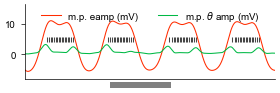

In [7]:
plt.style.use("analysis/config/paper.mplstyle")
plt.rcParams["axes.spines.top"]= False
fig,ax=plt.subplots(1,1,figsize=(3.234,0.97))
ax.eventplot(np.array(stell_spks_l[60])/1000,lineoffsets=5,color="#474747",linelengths=1.75,linewidths=0.75)
ax.plot(t/1000,ramp,c="#FF2C00",label='m.p. eamp (mV)',linewidth=0.75)
ax.plot(t/1000,amplitude_envelope_theta,c="#00B945",label='m.p. $\\theta$ amp (mV)',alpha=1,linewidth=0.75)
ax.legend(ncol=2,loc =(0.05,0.7),fontsize=7)
ax.set_xlim([18.6,22.7])
ax.set_ylim([-8,16.5])
rect = patches.Rectangle((20, -11),1, 2, edgecolor='none', facecolor='gray',clip_on=False)
ax.add_patch(rect)
plt.draw()
ax.set_xticks([])
plt.savefig(f'analysis/figures/Fig3/Fig3_A_top.svg')



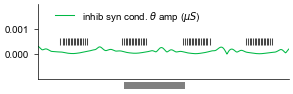

In [8]:
%matplotlib inline
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(2.834+0.4,0.97))
ax.eventplot(np.array(stell_spks_l[60])/1000,lineoffsets=0.0005,color="#474747",linelengths=0.0003,zorder=100,linewidths=0.75)
ax.plot(t/1000,amplitude_envelope_gsyn,c="#00B945",label='inhib syn cond. $\\theta$ amp ($\\mu S$)',alpha=1,linewidth=0.75)
ax.set_ylim([-0.001,0.002])
ax.set_xlim([18.6,22.7])
ax.legend(loc=(0.05,0.7),fontsize=7)
rect = patches.Rectangle((20, -0.0014),1, 0.00028, edgecolor='none', facecolor='gray',clip_on=False)
ax.add_patch(rect)
plt.draw()
ax.set_xticks([])
yticks = ax.get_yticks()
ax.set_yticks([yticks[1], yticks[-2]])
plt.savefig(f'analysis/figures/Fig3/Fig3_A_bottom.svg')


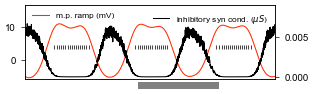

In [9]:
plt.style.use("analysis/config/paper.mplstyle")
plt.rcParams["axes.spines.right"]= True
plt.rcParams["axes.spines.top"]= True
fig,ax=plt.subplots(1,1,figsize=(2.834+0.4,0.97))
ax.eventplot(np.array(stell_spks_l[60])/1000,lineoffsets=4,color="#474747",linelengths=1.2,linewidths=0.75)
ax.plot(t/1000,ramp,c="#FF2C00",label='m.p. ramp (mV)',linewidth=0.75)
ax2 = ax.twinx()
ax2.plot(t/1000,stell_v_inhib_syn_g,c="k",label='inhibitory syn cond. ($\\mu S$)',alpha=1,linewidth=0.75)
ax.legend(loc="upper left",fontsize=6)
ax2.legend(loc="upper right",fontsize=6)
ax2.set_ylim([-0.0003,0.009])
ax.set_ylim([-6,17])
ax.set_xlim([18.6,21.7])
rect = patches.Rectangle((20, -9),1,2.05, edgecolor='none', facecolor='gray',clip_on=False)
ax.add_patch(rect)
plt.draw()
ax.set_xticks([])
plt.savefig(f'analysis/figures/Fig3/Fig3_C.svg')


In [34]:
sim_id = 'VALD-MPD-RAMP-S-s-1a'
params = s_utils.load_sim_params(sim_id)
stell_spks_l, intrnrn_spks_l = s_utils.load_spikes(sim_id)
t = np.arange(0,params['sim_dur'],params['dt'])
separated_fields = a_utils.separate_fields(stell_spks_l[:params["N_per_sheet"]],order=1)
field_size=int(a_utils.calc_grid_field_sizes_time(stell_spks_l[:params["N_per_sheet"]]))
off_field_size = []
for cell,fields in separated_fields.items():
    print(cell,end=" ")
    stell_v_1 = s_utils.load_data(sim_id,"stell_v",int(cell))
    stell_v_truncated = stell_v_1.copy()
    for field in fields:
        fspk = int((field[0]-15)/params['dt'])
        lspk = int((field[-1]+15)/params['dt'])
        temp_array=stell_v_truncated[fspk:lspk]
        temp_array[(temp_array>-40)] = np.nan
        temp_array[(temp_array<-78)] = np.nan
        stell_v_truncated[fspk:lspk]=temp_array
    t_trunc = t.copy()
    t_trunc[np.isnan(stell_v_truncated)]=np.nan
    stell_v_truncated = stell_v_truncated[~np.isnan(stell_v_truncated)]
    t_trunc = t_trunc[~np.isnan(t_trunc)]
    stell_interp = np.interp(t, t_trunc,stell_v_truncated)
    theta_filtered_v = band_pass(stell_interp, 4, 11,sample_rate=1/(0.025*1e-3),order=3)
    analytic_signal_theta = signal.hilbert(theta_filtered_v)
    amplitude_envelope_theta = np.abs(analytic_signal_theta)
    for i,curr_field in enumerate(fields[:-1]):
        next_field = fields[i+1]
        lspk = int((curr_field[-1])/params['dt'])
        off_field_size.append(next_field[0]-curr_field[-1])  

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 

In [35]:
sim_id = 'VALD-MPD-RAMP-S-s-1a'
params = s_utils.load_sim_params(sim_id)
stell_spks_l, intrnrn_spks_l = s_utils.load_spikes(sim_id)
t = np.arange(0,params['sim_dur'],params['dt'])
separated_fields = a_utils.separate_fields(stell_spks_l[:params["N_per_sheet"]],order=1)
field_size=int(a_utils.calc_grid_field_sizes_time(stell_spks_l[:params["N_per_sheet"]]))
avg_off_field_size=np.median(off_field_size) #median of off_field_size
theta_off_field =[]

for cell,fields in separated_fields.items():
    print(cell,end=" ")
    stell_v_1 = s_utils.load_data(sim_id,"stell_v",int(cell))
    stell_v_truncated = stell_v_1.copy()
    for field in fields:
        fspk = int((field[0]-15)/params['dt'])
        lspk = int((field[-1]+15)/params['dt'])
        temp_array=stell_v_truncated[fspk:lspk]
        temp_array[(temp_array>-40)] = np.nan
        temp_array[(temp_array<-78)] = np.nan
        stell_v_truncated[fspk:lspk]=temp_array
    t_trunc = t.copy()
    t_trunc[np.isnan(stell_v_truncated)]=np.nan
    stell_v_truncated = stell_v_truncated[~np.isnan(stell_v_truncated)]
    t_trunc = t_trunc[~np.isnan(t_trunc)]
    stell_interp = np.interp(t, t_trunc,stell_v_truncated)
    theta_filtered_v = band_pass(stell_interp, 4, 11,sample_rate=1/(0.025*1e-3),order=3)
    analytic_signal_theta = signal.hilbert(theta_filtered_v)
    amplitude_envelope_theta = np.abs(analytic_signal_theta)
    for i,curr_field in enumerate(fields[:-1]):
        look_behind = int((curr_field[0]-avg_off_field_size/2)/params['dt'])
        look_ahead = int((curr_field[0]+field_size+avg_off_field_size/2)/params['dt'])
        try:
            theta_off_field.append(amplitude_envelope_theta[look_behind:look_ahead])
        except IndexError:
            pass

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 

In [36]:
theta_off_field_clean = []
theta_off_field=theta_off_field[1:]
for i,thetas in enumerate(theta_off_field[:]):
    print(len(thetas),end=" ")
    if len(thetas)!=40275:
        continue
    theta_off_field_clean.append(thetas[:])

40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 0 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 40275 40275 40275 40275 40275 0 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 40275 40275 40275 40276 40275 40276 40275 40275 40275 40275 0 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 40275 0 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 40276 40275 40275 40275 40275 40275 40275 40275 40275 40275 0 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40275 40276 40275 

In [37]:
theta_off_field_avg =np.mean(np.array(theta_off_field_clean),axis=0)
t_off= np.linspace(-avg_off_field_size/2,avg_off_field_size/2+field_size,len(theta_off_field_avg))
theta_off_field_clean=np.array(theta_off_field_clean).astype("float16")
theta_off_field_clean_5=theta_off_field_clean[:,::5]
t_off_20 = t_off[::5]

combined_y = []
combined_x = []
for sig in theta_off_field_clean_5:
    for i,yval in enumerate(sig):
        combined_y.append(yval)
        combined_x.append(t_off_20[i])


In [38]:
h, xedges, yedges = np.histogram2d(combined_x, combined_y, bins=[500,1000])

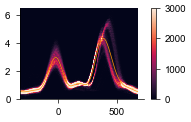

In [40]:
import seaborn as sns
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(figsize=(2,1.18))
cmap = plt.colormaps["rocket"]
plt.pcolormesh(xedges, yedges, h.T, cmap=cmap,vmax=3e3)
plt.colorbar()
plt.plot(np.linspace(-avg_off_field_size/2,field_size+avg_off_field_size/2,len(theta_off_field_avg)),theta_off_field_avg,c="#FF9500",linewidth=0.5)
# ax.axvline(field_size)
plt.ylim([0,6.5])
ax.tick_params(which="both",direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
plt.minorticks_off()
plt.savefig(f'analysis/figures/Fig3/Fig3_B',dpi=500)


